Train users columns: Index(['user_id', 'age', 'income', 'clicks', 'purchase_amount', 'label'], dtype='object')
Test users columns: Index(['user_id', 'age', 'income', 'clicks', 'purchase_amount', 'label'], dtype='object')
News columns: Index(['link', 'headline', 'category', 'short_description', 'authors', 'date'], dtype='object')
NaNs in train_users['user_label']: 0
NaNs in test_users['user_label']: 0

[Classification] Decision Tree Accuracy: 33.05%

[Training Epsilon-Greedy with ε=0.1]
[Training UCB with C=1]
[Training SoftMax with T=1.0]

[Final Reward Analysis for Epsilon-Greedy (ε=0.1)]
 Context=0, steps=10000, average reward=7.10
 Context=1, steps=10000, average reward=4.43
 Context=2, steps=10000, average reward=5.51
 Overall average reward across all contexts=5.68


[Final Reward Analysis for UCB (C=1)]
 Context=0, steps=10000, average reward=7.98
 Context=1, steps=10000, average reward=4.99
 Context=2, steps=10000, average reward=5.99
 Overall average reward across all contexts=

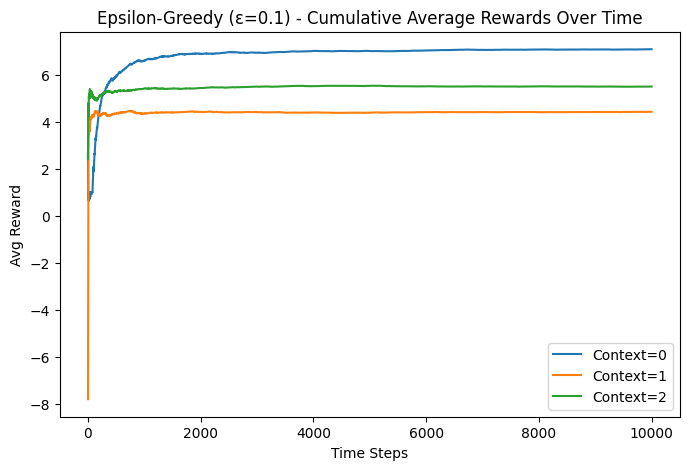

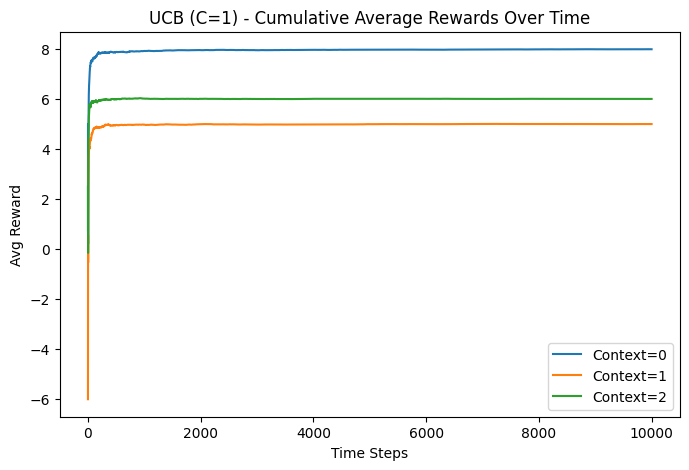

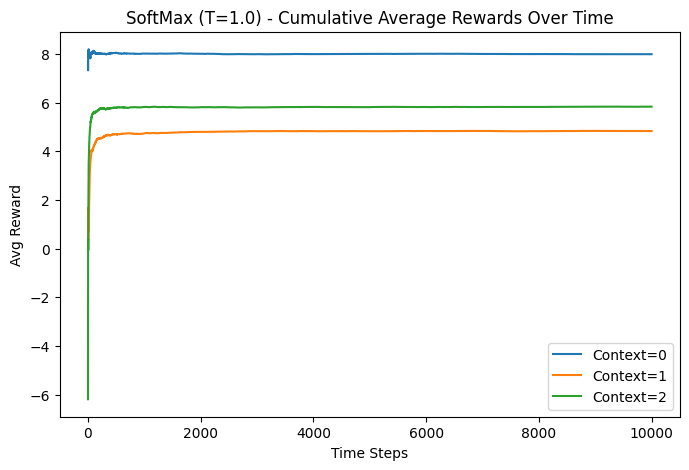

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from my_package.sampler import sampler  

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


# ----------------------------------------------------------
# STEP 1: DATA LOADING & PRE-PROCESSING
# ----------------------------------------------------------
train_users = pd.read_csv("train_users.csv")
test_users  = pd.read_csv("test_users.csv")
news_df     = pd.read_csv("news_articles.csv")

print("Train users columns:", train_users.columns)
print("Test users columns:", test_users.columns)
print("News columns:", news_df.columns)

# 1A. Clean up user labels
train_users['label'] = train_users['label'].astype(str).str.strip().str.title()
test_users['label']  = test_users['label'].astype(str).str.strip().str.title()

# Remove rows with missing labels
train_users.dropna(subset=['label'], inplace=True)
test_users.dropna(subset=['label'], inplace=True)

# Map user labels to numeric: (User1->0, User2->1, User3->2)
user_map = {'User1': 0, 'User2': 1, 'User3': 2}
train_users['user_label'] = train_users['label'].map(user_map)
test_users['user_label']  = test_users['label'].map(user_map)

# Drop rows that still have NaN in 'user_label' (unknown user category)
train_users.dropna(subset=['user_label'], inplace=True)
test_users.dropna(subset=['user_label'], inplace=True)

print("NaNs in train_users['user_label']:", train_users['user_label'].isnull().sum())
print("NaNs in test_users['user_label']:",  test_users['user_label'].isnull().sum())

# 1B. Clean up news categories
news_df['category'] = news_df['category'].astype(str).str.strip().str.title()


# Map only these 4 categories: Entertainment->0, Education->1, Tech->2, Crime->3
news_map = {'Entertainment': 0, 'Education': 1, 'Tech': 2, 'Crime': 3}
news_df['news_label'] = news_df['category'].map(news_map)

# Drop rows that do not match the above 4 categories
news_df.dropna(subset=['news_label'], inplace=True)



# ----------------------------------------------------------
# STEP 2: USER CLASSIFICATION (DECISION TREE)
# ----------------------------------------------------------
X_train = train_users[['age', 'income', 'clicks', 'purchase_amount']]
y_train = train_users['user_label']

X_test = test_users[['age', 'income', 'clicks', 'purchase_amount']]
y_test = test_users['user_label']

clf = DecisionTreeClassifier(random_state=42, max_depth=5)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n[Classification] Decision Tree Accuracy: {acc*100:.2f}%")


# ----------------------------------------------------------
# STEP 3: CONTEXTUAL BANDITS
# ----------------------------------------------------------
# We have 3 contexts (0->User1,1->User2,2->User3) and 4 arms (0->Entertainment,1->Education,2->Tech,3->Crime).

contexts = [0, 1, 2]
num_arms = 4

# Instantiate the sampler with your roll number's last digits
roll_number = 11  # Example
reward_sampler = sampler(roll_number)

def get_arm_index(context, arm):
    """
    Each context c has 4 arms:
       j = c * 4 + arm
    => j in {0..11}
    """
    return context * num_arms + arm


# ----------------------------------------------------------
# Storing ACTUAL rewards (not Q-values) for plotting
# ----------------------------------------------------------

def train_epsilon_greedy(epsilon=0.1, T=10000):
    """
    Returns:
      Q   : Q-value dictionary {c: [Q_arm0, Q_arm1, Q_arm2, Q_arm3]}
      R_h : actual_rewards_history, {c: list_of_rewards_per_step}
    """
    Q = {c: [0.0]*num_arms for c in contexts}
    N = {c: [0]*num_arms for c in contexts}

    actual_rewards_history = {c: [] for c in contexts}

    for c in contexts:
        for t in range(1, T+1):
            # Epsilon-greedy action
            if np.random.rand() < epsilon:
                arm = np.random.randint(num_arms)
            else:
                arm = np.argmax(Q[c])

            j = get_arm_index(c, arm)
            r = reward_sampler.sample(j)  # Actual reward from the environment

            # Update Q-values
            N[c][arm] += 1
            Q[c][arm] += (r - Q[c][arm]) / N[c][arm]

            # Store the actual reward for plotting
            actual_rewards_history[c].append(r)

    return Q, actual_rewards_history


def train_ucb(C=1, T=10000):
    Q = {c: [0.0]*num_arms for c in contexts}
    N = {c: [0]*num_arms for c in contexts}
    actual_rewards_history = {c: [] for c in contexts}

    for c in contexts:
        for t in range(1, T+1):
            ucb_values = []
            for arm in range(num_arms):
                if N[c][arm] == 0:
                    ucb_values.append(float('inf'))
                else:
                    bonus = C * math.sqrt(math.log(t)/N[c][arm])
                    ucb_values.append(Q[c][arm] + bonus)

            arm = np.argmax(ucb_values)
            j = get_arm_index(c, arm)
            r = reward_sampler.sample(j)

            # Update
            N[c][arm] += 1
            Q[c][arm] += (r - Q[c][arm]) / N[c][arm]

            # Store actual reward
            actual_rewards_history[c].append(r)

    return Q, actual_rewards_history


def train_softmax(temperature=1.0, T=10000):
    Q = {c: [0.0]*num_arms for c in contexts}
    N = {c: [0]*num_arms for c in contexts}
    actual_rewards_history = {c: [] for c in contexts}

    for c in contexts:
        for t in range(1, T+1):
            exp_vals = np.exp(np.array(Q[c]) / temperature)
            probs = exp_vals / np.sum(exp_vals)
            arm = np.random.choice(num_arms, p=probs)

            j = get_arm_index(c, arm)
            r = reward_sampler.sample(j)

            N[c][arm] += 1
            Q[c][arm] += (r - Q[c][arm]) / N[c][arm]

            # Store actual reward
            actual_rewards_history[c].append(r)

    return Q, actual_rewards_history


# ----------------------------------------------------------
# Train the bandit models
# ----------------------------------------------------------
print("\n[Training Epsilon-Greedy with ε=0.1]")
egreedy_Q_01, egreedy_rewards_01 = train_epsilon_greedy(epsilon=0.1, T=10000)

print("[Training UCB with C=1]")
ucb_Q_1, ucb_rewards_1 = train_ucb(C=1, T=10000)

print("[Training SoftMax with T=1.0]")
softmax_Q_1, softmax_rewards_1 = train_softmax(temperature=1.0, T=10000)

# ----------------------------------------------------------
# Print Final Reward Findings
# ----------------------------------------------------------
def print_final_rewards_info(name, actual_rewards_history):
    """
    name: str, name of the policy ("Epsilon-Greedy", "UCB", "SoftMax")
    actual_rewards_history: {c: list_of_rewards}
    """
    print(f"\n[Final Reward Analysis for {name}]")
    all_rewards = []
    for c in contexts:
        c_rewards = actual_rewards_history[c]
        avg_c = np.mean(c_rewards)
        print(f" Context={c}, steps={len(c_rewards)}, average reward={avg_c:.2f}")
        all_rewards.extend(c_rewards)
    overall_avg = np.mean(all_rewards) if len(all_rewards) > 0 else 0
    print(f" Overall average reward across all contexts={overall_avg:.2f}\n")


print_final_rewards_info("Epsilon-Greedy (ε=0.1)", egreedy_rewards_01)
print_final_rewards_info("UCB (C=1)", ucb_rewards_1)
print_final_rewards_info("SoftMax (T=1.0)", softmax_rewards_1)


# ----------------------------------------------------------
# STEP 4: MAKE A RECOMMENDATION
# ----------------------------------------------------------
def recommend_article(user_features, bandit_models, classifier, news_df):
    """
    user_features: array-like [age, income, clicks, purchase_amount]
    bandit_models: dict with keys = {'egreedy','ucb','softmax'} and values = Q dict
    classifier   : Decision Tree or other model to predict user_label
    news_df      : news DataFrame with 'news_label' for each article
    """
    col_names = ['age','income','clicks','purchase_amount']
    user_df = pd.DataFrame([user_features], columns=col_names)

    # Predict user context
    context_pred = classifier.predict(user_df)[0]  # 0..2

    cat_map = {0:'Entertainment',1:'Education',2:'Tech',3:'Crime'}
    recommendations = {}

    for policy_name, Q_dict in bandit_models.items():
        Q_vals = Q_dict[context_pred]
        best_arm = np.argmax(Q_vals)
        best_cat = cat_map[best_arm]

        # Pick random article from best_cat
        matching = news_df[news_df['news_label'] == best_arm]
        if not matching.empty:
            article_row = matching.sample(1).iloc[0]
            recommendations[policy_name] = {
                'category': best_cat,
                'headline': article_row['headline'],
                'link': article_row['link']
            }
        else:
            recommendations[policy_name] = {
                'category': best_cat,
                'headline': None,
                'link': None
            }

    return recommendations


# Example usage
all_bandit_Q = {
    'egreedy': egreedy_Q_01,
    'ucb': ucb_Q_1,
    'softmax': softmax_Q_1
}

print("\n[Recommendations for new user]:")
new_user = [29, 29862, 91, 270.91]  # [age, income, clicks, purchase_amount]

recs = recommend_article(new_user, all_bandit_Q, clf, news_df)
for policy, info in recs.items():
    print(f"  - {policy}: Category={info['category']}, Headline={info['headline']}")


# ----------------------------------------------------------
# STEP 5: EVALUATION & ANALYSIS
# Plot the CUMULATIVE AVERAGE of the ACTUAL rewards
# ----------------------------------------------------------
def plot_cumulative_rewards(actual_rewards, contexts, policy_label):
    """
    actual_rewards: dict {c: list_of_rewards_per_step}
    contexts: e.g. [0,1,2]
    policy_label: 'Epsilon-Greedy (ε=0.1)' or 'UCB (C=1)' or 'SoftMax (T=1.0)'
    """
    plt.figure(figsize=(8,5))
    for c in contexts:
        r_array = np.array(actual_rewards[c])  # shape (T,)
        # Cumulative sum: r[1]+...+r[t]
        cumsum = np.cumsum(r_array)
        # Running average
        running_avg = cumsum / np.arange(1, len(r_array) + 1)

        plt.plot(running_avg, label=f"Context={c}")

    plt.title(f"{policy_label} - Cumulative Average Rewards Over Time")
    plt.xlabel("Time Steps")
    plt.ylabel("Avg Reward")
    plt.legend()
    plt.show()

# Separate plots for each policy
plot_cumulative_rewards(egreedy_rewards_01, contexts, "Epsilon-Greedy (ε=0.1)")
plot_cumulative_rewards(ucb_rewards_1, contexts, "UCB (C=1)")
plot_cumulative_rewards(softmax_rewards_1, contexts, "SoftMax (T=1.0)")


In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=["User1", "User2", "User3"]))

              precision    recall  f1-score   support

       User1       0.32      0.26      0.29       672
       User2       0.34      0.51      0.41       679
       User3       0.33      0.21      0.26       649

    accuracy                           0.33      2000
   macro avg       0.33      0.33      0.32      2000
weighted avg       0.33      0.33      0.32      2000




[COMPARING MULTIPLE HYPERPARAMETERS WITH PRINTED EXPECTED REWARDS + PLOTS]




==== Epsilon-Greedy (Hyperparam=0.1) - Actual Rewards ====
  Context=0: Average Actual Reward = 7.133 over 10000 steps.
  Context=1: Average Actual Reward = 4.433 over 10000 steps.
  Context=2: Average Actual Reward = 5.524 over 10000 steps.
  Overall average actual reward = 5.697


[Final Q-Values (Expected Rewards) for Epsilon-Greedy, Hyperparam=0.1]
  Context=0:
    Arm=0 (Entertainment): Q = 0.995
    Arm=1 (Education): Q = 8.000
    Arm=2 (Tech): Q = -7.906
    Arm=3 (Crime): Q = -2.065
  Context=1:
    Arm=0 (Entertainment): Q = -7.040
    Arm=1 (Education): Q = 4.996
    Arm=2 (Tech): Q = 1.963
    Arm=3 (Crime): Q = -2.964
  Context=2:
    Arm=0 (Entertainment): Q = 2.946
    Arm=1 (Education): Q = -0.027
    Arm=2 (Tech): Q = -4.059
    Arm=3 (Crime): Q = 6.006



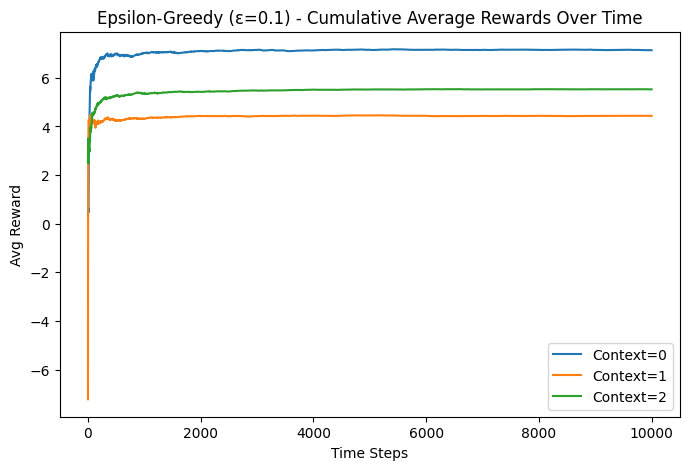


==== Epsilon-Greedy (Hyperparam=0.5) - Actual Rewards ====
  Context=0: Average Actual Reward = 3.828 over 10000 steps.
  Context=1: Average Actual Reward = 2.097 over 10000 steps.
  Context=2: Average Actual Reward = 3.627 over 10000 steps.
  Overall average actual reward = 3.184


[Final Q-Values (Expected Rewards) for Epsilon-Greedy, Hyperparam=0.5]
  Context=0:
    Arm=0 (Entertainment): Q = 0.980
    Arm=1 (Education): Q = 8.002
    Arm=2 (Tech): Q = -8.019
    Arm=3 (Crime): Q = -2.030
  Context=1:
    Arm=0 (Entertainment): Q = -6.996
    Arm=1 (Education): Q = 5.017
    Arm=2 (Tech): Q = 1.998
    Arm=3 (Crime): Q = -3.028
  Context=2:
    Arm=0 (Entertainment): Q = 2.947
    Arm=1 (Education): Q = 0.033
    Arm=2 (Tech): Q = -4.029
    Arm=3 (Crime): Q = 6.006



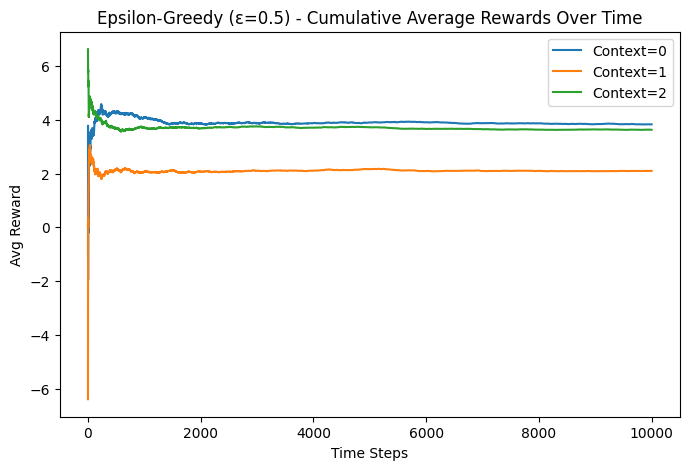


==== Epsilon-Greedy (Hyperparam=0.7) - Actual Rewards ====
  Context=0: Average Actual Reward = 2.251 over 10000 steps.
  Context=1: Average Actual Reward = 0.952 over 10000 steps.
  Context=2: Average Actual Reward = 2.598 over 10000 steps.
  Overall average actual reward = 1.934


[Final Q-Values (Expected Rewards) for Epsilon-Greedy, Hyperparam=0.7]
  Context=0:
    Arm=0 (Entertainment): Q = 0.975
    Arm=1 (Education): Q = 8.007
    Arm=2 (Tech): Q = -7.970
    Arm=3 (Crime): Q = -1.976
  Context=1:
    Arm=0 (Entertainment): Q = -7.003
    Arm=1 (Education): Q = 5.035
    Arm=2 (Tech): Q = 1.945
    Arm=3 (Crime): Q = -2.980
  Context=2:
    Arm=0 (Entertainment): Q = 3.003
    Arm=1 (Education): Q = 0.004
    Arm=2 (Tech): Q = -3.972
    Arm=3 (Crime): Q = 5.976



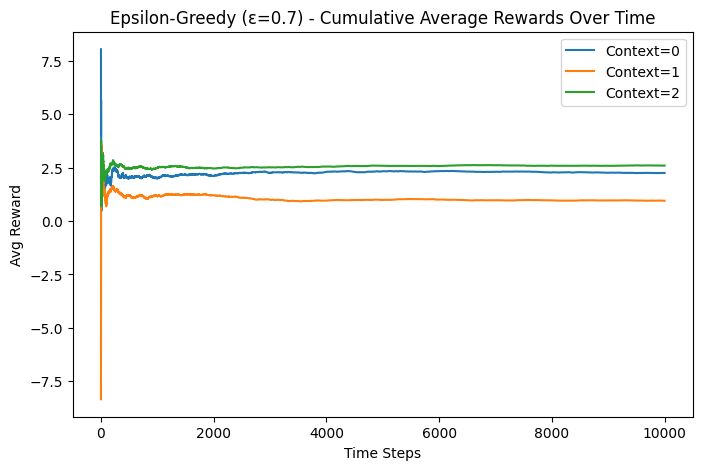


==== UCB (Hyperparam=1) - Actual Rewards ====
  Context=0: Average Actual Reward = 8.002 over 10000 steps.
  Context=1: Average Actual Reward = 5.004 over 10000 steps.
  Context=2: Average Actual Reward = 5.992 over 10000 steps.
  Overall average actual reward = 6.333


[Final Q-Values (Expected Rewards) for UCB, Hyperparam=1]
  Context=0:
    Arm=0 (Entertainment): Q = 1.372
    Arm=1 (Education): Q = 8.005
    Arm=2 (Tech): Q = -7.871
    Arm=3 (Crime): Q = -0.168
  Context=1:
    Arm=0 (Entertainment): Q = -9.611
    Arm=1 (Education): Q = 5.007
    Arm=2 (Tech): Q = 1.692
    Arm=3 (Crime): Q = -2.941
  Context=2:
    Arm=0 (Entertainment): Q = 2.912
    Arm=1 (Education): Q = 0.045
    Arm=2 (Tech): Q = -5.713
    Arm=3 (Crime): Q = 5.994



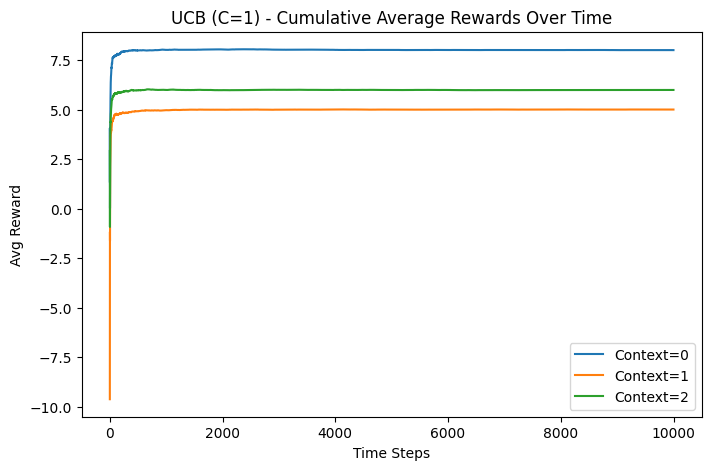


==== UCB (Hyperparam=2) - Actual Rewards ====
  Context=0: Average Actual Reward = 7.988 over 10000 steps.
  Context=1: Average Actual Reward = 4.991 over 10000 steps.
  Context=2: Average Actual Reward = 6.004 over 10000 steps.
  Overall average actual reward = 6.328


[Final Q-Values (Expected Rewards) for UCB, Hyperparam=2]
  Context=0:
    Arm=0 (Entertainment): Q = 0.681
    Arm=1 (Education): Q = 7.991
    Arm=2 (Tech): Q = -8.565
    Arm=3 (Crime): Q = -2.253
  Context=1:
    Arm=0 (Entertainment): Q = -4.875
    Arm=1 (Education): Q = 4.994
    Arm=2 (Tech): Q = 1.489
    Arm=3 (Crime): Q = -1.824
  Context=2:
    Arm=0 (Entertainment): Q = 2.728
    Arm=1 (Education): Q = -1.548
    Arm=2 (Tech): Q = -5.127
    Arm=3 (Crime): Q = 6.007



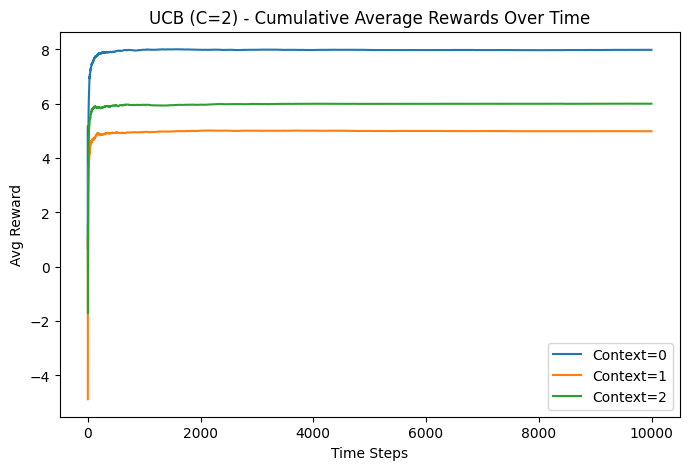


==== UCB (Hyperparam=3) - Actual Rewards ====
  Context=0: Average Actual Reward = 7.983 over 10000 steps.
  Context=1: Average Actual Reward = 4.990 over 10000 steps.
  Context=2: Average Actual Reward = 6.009 over 10000 steps.
  Overall average actual reward = 6.327


[Final Q-Values (Expected Rewards) for UCB, Hyperparam=3]
  Context=0:
    Arm=0 (Entertainment): Q = 0.511
    Arm=1 (Education): Q = 7.987
    Arm=2 (Tech): Q = -7.587
    Arm=3 (Crime): Q = -1.394
  Context=1:
    Arm=0 (Entertainment): Q = -7.303
    Arm=1 (Education): Q = 4.996
    Arm=2 (Tech): Q = 2.191
    Arm=3 (Crime): Q = -2.842
  Context=2:
    Arm=0 (Entertainment): Q = 3.314
    Arm=1 (Education): Q = -0.419
    Arm=2 (Tech): Q = -2.910
    Arm=3 (Crime): Q = 6.016



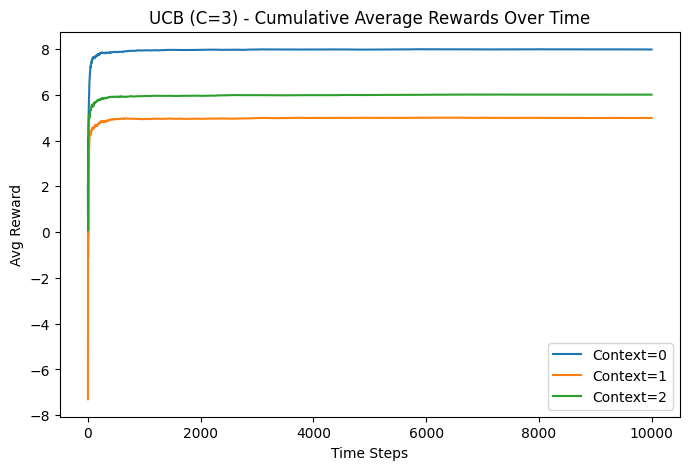


==== SoftMax (Hyperparam=0.5) - Actual Rewards ====
  Context=0: Average Actual Reward = 7.998 over 10000 steps.
  Context=1: Average Actual Reward = 5.010 over 10000 steps.
  Context=2: Average Actual Reward = 5.560 over 10000 steps.
  Overall average actual reward = 6.189


[Final Q-Values (Expected Rewards) for SoftMax, Hyperparam=0.5]
  Context=0:
    Arm=0 (Entertainment): Q = 0.000
    Arm=1 (Education): Q = 8.000
    Arm=2 (Tech): Q = -9.187
    Arm=3 (Crime): Q = 0.000
  Context=1:
    Arm=0 (Entertainment): Q = 0.000
    Arm=1 (Education): Q = 5.011
    Arm=2 (Tech): Q = 0.000
    Arm=3 (Crime): Q = -3.700
  Context=2:
    Arm=0 (Entertainment): Q = 2.978
    Arm=1 (Education): Q = 0.149
    Arm=2 (Tech): Q = -4.642
    Arm=3 (Crime): Q = 6.011



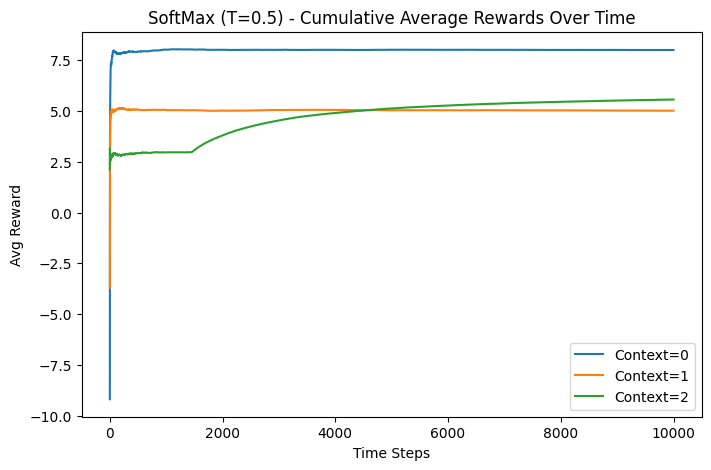


==== SoftMax (Hyperparam=1.0) - Actual Rewards ====
  Context=0: Average Actual Reward = 7.975 over 10000 steps.
  Context=1: Average Actual Reward = 4.883 over 10000 steps.
  Context=2: Average Actual Reward = 5.835 over 10000 steps.
  Overall average actual reward = 6.231


[Final Q-Values (Expected Rewards) for SoftMax, Hyperparam=1.0]
  Context=0:
    Arm=0 (Entertainment): Q = -0.011
    Arm=1 (Education): Q = 7.980
    Arm=2 (Tech): Q = -8.068
    Arm=3 (Crime): Q = -1.688
  Context=1:
    Arm=0 (Entertainment): Q = -5.815
    Arm=1 (Education): Q = 5.001
    Arm=2 (Tech): Q = 1.936
    Arm=3 (Crime): Q = -3.540
  Context=2:
    Arm=0 (Entertainment): Q = 3.047
    Arm=1 (Education): Q = -0.202
    Arm=2 (Tech): Q = -5.772
    Arm=3 (Crime): Q = 6.006



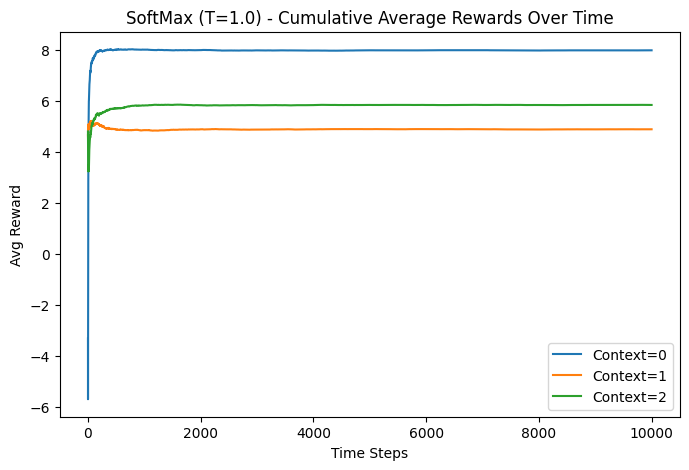


==== SoftMax (Hyperparam=2.0) - Actual Rewards ====
  Context=0: Average Actual Reward = 7.715 over 10000 steps.
  Context=1: Average Actual Reward = 4.303 over 10000 steps.
  Context=2: Average Actual Reward = 5.169 over 10000 steps.
  Overall average actual reward = 5.729


[Final Q-Values (Expected Rewards) for SoftMax, Hyperparam=2.0]
  Context=0:
    Arm=0 (Entertainment): Q = 0.968
    Arm=1 (Education): Q = 8.005
    Arm=2 (Tech): Q = -8.668
    Arm=3 (Crime): Q = -1.936
  Context=1:
    Arm=0 (Entertainment): Q = -7.257
    Arm=1 (Education): Q = 4.999
    Arm=2 (Tech): Q = 1.991
    Arm=3 (Crime): Q = -3.030
  Context=2:
    Arm=0 (Entertainment): Q = 3.011
    Arm=1 (Education): Q = 0.003
    Arm=2 (Tech): Q = -3.820
    Arm=3 (Crime): Q = 5.993



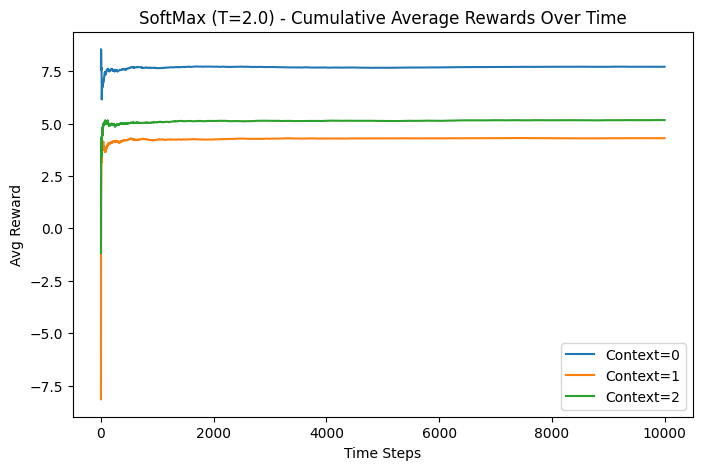

In [26]:
########################
# MULTIPLE HYPERPARAMETERS EXAMPLE
########################
def print_expected_rewards(policy_name, hyperparam, Q_dict, contexts):
    """
    Prints the final Q-values (learned expected rewards) for each context and arm.
      - policy_name:  'Epsilon-Greedy', 'UCB', or 'SoftMax'
      - hyperparam:   the hyperparameter value (e.g. 0.1, 2, 1.0)
      - Q_dict:       the dictionary returned after training, e.g. Q_dict[c] = [Q_arm0, Q_arm1, ...]
      - contexts:     the list of context IDs, e.g. [0,1,2]
    """
    cat_map = {0:'Entertainment',1:'Education',2:'Tech',3:'Crime'}
    print(f"\n[Final Q-Values (Expected Rewards) for {policy_name}, Hyperparam={hyperparam}]")
    for c in contexts:
        print(f"  Context={c}:")
        for arm_idx, q_val in enumerate(Q_dict[c]):
            category_name = cat_map.get(arm_idx, f"Arm{arm_idx}")
            print(f"    Arm={arm_idx} ({category_name}): Q = {q_val:.3f}")
    print()

def print_average_rewards(policy_name, hyperparam, actual_rewards_history, contexts):
    """
    Prints the final average actual reward for each context, plus overall average.
    """
    print(f"\n==== {policy_name} (Hyperparam={hyperparam}) - Actual Rewards ====")
    all_rewards = []
    for c in contexts:
        c_rewards = actual_rewards_history[c]
        avg_c = np.mean(c_rewards) if len(c_rewards) else 0
        print(f"  Context={c}: Average Actual Reward = {avg_c:.3f} over {len(c_rewards)} steps.")
        all_rewards.extend(c_rewards)
    overall_avg = np.mean(all_rewards) if len(all_rewards) else 0
    print(f"  Overall average actual reward = {overall_avg:.3f}\n")


# Hyperparameter sets to compare
epsilons   = [0.1, 0.5, 0.7]    # Epsilon-Greedy
C_values   = [1, 2, 3]          # UCB
temp_values= [0.5, 1.0, 2.0]    # SoftMax

print("\n[COMPARING MULTIPLE HYPERPARAMETERS WITH PRINTED EXPECTED REWARDS + PLOTS]\n")

# 1. Epsilon-Greedy
for eps in epsilons:
    # Train
    Q_e, rewards_e = train_epsilon_greedy(epsilon=eps, T=10000)
    # Print actual rewards
    print_average_rewards("Epsilon-Greedy", eps, rewards_e, contexts)
    # Print final Q-values (expected rewards)
    print_expected_rewards("Epsilon-Greedy", eps, Q_e, contexts)
    # Plot cumulative average reward
    plot_cumulative_rewards(rewards_e, contexts, f"Epsilon-Greedy (ε={eps})")


# 2. UCB
for c_val in C_values:
    # Train
    Q_u, rewards_u = train_ucb(C=c_val, T=10000)
    # Print actual rewards
    print_average_rewards("UCB", c_val, rewards_u, contexts)
    # Print final Q-values
    print_expected_rewards("UCB", c_val, Q_u, contexts)
    # Plot cumulative average
    plot_cumulative_rewards(rewards_u, contexts, f"UCB (C={c_val})")


# 3. SoftMax
for temp in temp_values:
    # Train
    Q_s, rewards_s = train_softmax(temperature=temp, T=10000)
    # Print actual rewards
    print_average_rewards("SoftMax", temp, rewards_s, contexts)
    # Print final Q-values
    print_expected_rewards("SoftMax", temp, Q_s, contexts)
    # Plot cumulative average
    plot_cumulative_rewards(rewards_s, contexts, f"SoftMax (T={temp})")

